In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()


In [4]:
data = load_coco_data(pca_features=True)

In [5]:
data['val_features'].shape[1]

512

In [6]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
idx_to_word <class 'list'> 1004
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
val_features <class 'numpy.ndarray'> (40504, 512) float32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_features <class 'numpy.ndarray'> (82783, 512) float32


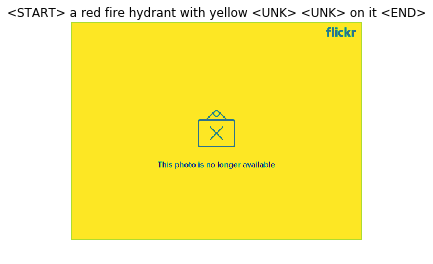

In [7]:
show_image(1)

In [8]:
def sparse_to_one_hot(sparse_input, max_dim):
    one_hot = np.zeros((sparse_input.shape[0], max_dim))
    for idx, input_index in enumerate(sparse_input):
        one_hot[idx, input_index] = 1
    return one_hot

def captions_to_one_hot(captions, vocab_dim):
    return [sparse_to_one_hot(sentence, vocab_dim) for sentence in captions]

def captions_to_target(captions, null_token_represenation):
    
    def trim_left_and_pad_right(caption):
        """
        Convert training data:
        '<START> a variety of fruits and vegetables sitting on a kitchen counter <END>'
        to target:
        'a variety of fruits and vegetables sitting on a kitchen counter <END> <NULL>'
        """
        return np.append(caption[1::], null_token_represenation)
    
    return [trim_left_and_pad_right(c) for c in captions]

def verify_caption_train_target_offset(train_caption, target_caption):
    for i in range(len(target_caption) - 1):
        assert train_caption[i + 1] == target_caption[i]

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]

## model params
word_embedding_dim = 256
hidden_dim = 512
learning_rate = 5e-4

def get_train_target_caption(train_captions_as_word_ids, to_one_hot = True):
    """
        convert captions from word ids to representations [N, T, V], batch size, time step, and vocab size
    """

    target_captions_as_word_ids = captions_to_target(train_captions_as_word_ids, data['word_to_idx'][NULL_TOKEN])
    verify_caption_train_target_offset(train_captions_as_word_ids[0], target_captions_as_word_ids[0])

    if (to_one_hot == False):
        return train_captions_as_word_ids, target_captions_as_word_ids
    else:
        train_captions = captions_to_one_hot(train_captions_as_word_ids, vocab_dim)
        return train_captions, target_captions

In [10]:
manual_one_hot = False

if manual_one_hot:
    sy_caption_input = tf.placeholder(shape=[None, None, vocab_dim], name="caption_input", dtype=tf.float32)
    word_embedding = layer_utils.build_mlp(sy_caption_input, word_embedding_dim, 'word_embedding', activation=tf.nn.relu,  n_layers=1)
else:
    sy_caption_input = tf.placeholder(shape=[None, None], name="caption_input", dtype=tf.int32)
    embedding = tf.get_variable("embedding", [vocab_dim, word_embedding_dim], dtype=tf.float32)
    word_embedding = tf.nn.embedding_lookup(embedding, sy_caption_input)

sy_caption_target = tf.placeholder(shape=[None, None], name="caption_target", dtype=tf.int64)


## Model

In [11]:
sy_image_feat_input = tf.placeholder(shape=[None, image_feature_dim], name="image_feat_input", dtype=tf.float32)
image_projection = layer_utils.affine_transform(sy_image_feat_input, image_feature_dim, 'image_proj')
initial_cell_state = image_projection * 0
initial_lstm_state = tf.nn.rnn_cell.LSTMStateTuple(initial_cell_state, image_projection)


In [12]:
# LSTM
cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_dim)
outputs, final = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32, initial_state=initial_lstm_state)
hidden_to_word = layer_utils.affine_transform(outputs, vocab_dim, 'hidden_to_word')


# Produce not-null mask. Padded words are null and has 0 mask
mask_not_null = tf.cast(tf.not_equal(sy_caption_target, NULL_ID), dtype=tf.float32)
# Get total non-null words to be predicted
total_predictions = tf.cast(tf.reduce_sum(mask_not_null), tf.float32)

# Process entropy from logits and one-hot target
target_one_hot = tf.one_hot(sy_caption_target, vocab_dim, dtype=tf.int64)
raw_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=target_one_hot, logits=hidden_to_word)
masked_cross_entropy = raw_cross_entropy * mask_not_null
cross_entropy = tf.reduce_mean(tf.reduce_sum(masked_cross_entropy, axis=1))
update_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction accuracy
prediction = tf.argmax(hidden_to_word, axis = 2)
correct_pred = tf.equal(prediction, sy_caption_target)
accuracy = tf.reduce_sum(tf.cast(correct_pred, tf.float32))/total_predictions

print("-- Input tensors --")
print("word embedding shape: ", word_embedding)
print("hidden lstm: ", hidden_to_word)

print("\n-- Loss tensors --")
print("Target one hot: ", target_one_hot)
print("Mask not null: ", mask_not_null)
print("Raw cross entropy: ", raw_cross_entropy)
print("Masked cross entropy: ", cross_entropy)
print("Cross entropy: ", cross_entropy)

print("\n-- Prediction tensors --")
print("target given: ", sy_caption_target)
print("correct_pred prediction shape:", accuracy)


-- Input tensors --
word embedding shape:  Tensor("embedding_lookup:0", shape=(?, ?, 256), dtype=float32)
hidden lstm:  Tensor("hidden_to_word/dense/BiasAdd:0", shape=(?, ?, 1004), dtype=float32)

-- Loss tensors --
Target one hot:  Tensor("one_hot:0", shape=(?, ?, 1004), dtype=int64)
Mask not null:  Tensor("Cast:0", shape=(?, ?), dtype=float32)
Raw cross entropy:  Tensor("Reshape_2:0", shape=(?, ?), dtype=float32)
Masked cross entropy:  Tensor("Mean:0", shape=(), dtype=float32)
Cross entropy:  Tensor("Mean:0", shape=(), dtype=float32)

-- Prediction tensors --
target given:  Tensor("caption_target:0", shape=(?, ?), dtype=int64)
correct_pred prediction shape: Tensor("truediv:0", shape=(), dtype=float32)


In [13]:
def sample_caption(session, initial_word, image_feature, limit_length):
    
    generated_word_idx = []
    for _ in range(limit_length):
        caption_input = [[initial_word]]
        pred = session.run(prediction,feed_dict =
                           {sy_caption_input: caption_input,
                           sy_image_feat_input: features
                           })[0][0]
        
        if type(initial_word) is list:
            next_word_input = np.zeros(len(initial_word))
            next_word_input[pred] = 1
            initial_word = next_word_input
        else:
            initial_word = pred

        generated_word_idx.append(pred)
    print (decode_captions(np.array(generated_word_idx), data['idx_to_word']))
    return generated_word_idx

### Training

In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [15]:
iter_num = 100
embeddings = []
for i in range(iter_num):
    mini_batch, features, url = sample_coco_minibatch(data,  batch_size=100, split='train')
    train_captions, target_captions = get_train_target_caption(mini_batch, to_one_hot=False)
#     o, c, m, a, p, cp = sess.run([update_op, reduced_cross_entropy, masked_cross_entropy, accuracy, prediction, correct_pred], {sy_caption_input: train_captions, sy_caption_target: target_captions})
    _, c, a = sess.run([update_op, cross_entropy, accuracy], feed_dict=
                       {sy_image_feat_input: features,
                        sy_caption_input: train_captions, 
                        sy_caption_target: target_captions
                       })
    print("iter {}, cross-entropy: {}, accuracy: {}".format(i, c, a))
#     if (i%20 == 0):
#         sample_caption(sess, train_captions[0][1], 17)
        

iter 0, cross-entropy: 76.98063659667969, accuracy: 0.0008976660901680589
iter 1, cross-entropy: 77.67218780517578, accuracy: 0.00711111119017005
iter 2, cross-entropy: 77.29979705810547, accuracy: 0.01869991049170494
iter 3, cross-entropy: 77.86027526855469, accuracy: 0.03883495181798935
iter 4, cross-entropy: 77.66619873046875, accuracy: 0.07760141044855118
iter 5, cross-entropy: 76.12541198730469, accuracy: 0.11210761964321136
iter 6, cross-entropy: 73.36913299560547, accuracy: 0.13531047105789185
iter 7, cross-entropy: 76.0527572631836, accuracy: 0.1666666716337204
iter 8, cross-entropy: 75.74513244628906, accuracy: 0.16160714626312256
iter 9, cross-entropy: 75.77684783935547, accuracy: 0.15794143080711365
iter 10, cross-entropy: 74.22819519042969, accuracy: 0.1723826676607132
iter 11, cross-entropy: 72.6464614868164, accuracy: 0.18693284690380096
iter 12, cross-entropy: 72.63824462890625, accuracy: 0.1964125633239746
iter 13, cross-entropy: 69.96357727050781, accuracy: 0.211678832